# Project: **Finding Lane Lines on the Road** 
***

In [95]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


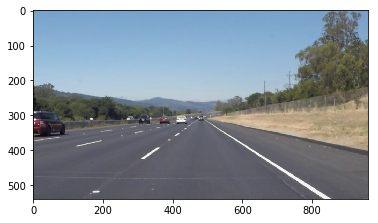

In [96]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Lane Detection Pipeline

In [97]:
import math

def black_yellow_filter(image):
    """Applies white and yellow filter to the image"""
    # White threshold limit (upper and lower)
    w_low = np.array([200, 200, 200])
    w_up = np.array([255, 255, 255])
    
    # Yellow threshold limit (upper and lower)
    y_low = np.array([150,120,20])
    y_up = np.array([240,220,100])
    
    # Applies white mask
    w_mask = cv2.inRange(image, w_low, w_up)
    w_image = cv2.bitwise_and(image, image, mask=w_mask)

    # Applies yellow mask
    y_mask = cv2.inRange(image, y_low, y_up)
    y_image = cv2.bitwise_and(image, image, mask=y_mask)

    # Combine the two above images α=1., y_image, β=1., λ=0
    filter_image = cv2.addWeighted(w_image, 1., y_image, 1., 0.)

    return filter_image

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask"""
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """This function draws `lines` with `color` and `thickness`"""
    # create empty to store x and y points for left and right lane
    r_lane_x = []
    r_lane_y = []
    l_lane_x = []
    l_lane_y = []
    
    # limits in y axis to draw lines
    y_1 = img.shape[0]
    y_2 = int(img.shape[0]*0.6)
    
    # mid point in x axis to separate lines as left or right
    mid = int(img.shape[1]*0.53)
    
    # right and left threshold
    r_thresh = 0.45
    l_thresh = -0.55
    
    # separate lines as per slopes and location 
    # append into corresponding right or left lanes
    for line in lines:
        for x1,y1,x2,y2 in line:
            # print(line)
            # print((y2 - y1)/(x2 - x1))
            if x2-x1 != 0:
                if (y2-y1)/(x2-x1) > r_thresh and x1>mid and x2>mid:
                    r_lane_x.append(x1)
                    r_lane_x.append(x2)
                    r_lane_y.append(y1)
                    r_lane_y.append(y2)
                elif (y2-y1)/(x2-x1) < l_thresh and x1<mid and x2<mid:
                    l_lane_x.append(x1)
                    l_lane_x.append(x2)
                    l_lane_y.append(y1)
                    l_lane_y.append(y2)
            else:
                if x1>mid and x2>mid:
                    r_lane_x.append(x1)
                    r_lane_x.append(x2)
                    r_lane_y.append(y1)
                    r_lane_y.append(y2)
                elif x1<mid and x2<mid:
                    l_lane_x.append(x1)
                    l_lane_x.append(x2)
                    l_lane_y.append(y1)
                    l_lane_y.append(y2)
    
    # if right lanes exist then fit a single degree line for the available x and y points
    # find x1 and x2 values from the slope and intercept values obtained through polyfit
    # draw line of thickness on actual image
    if len(r_lane_x) > 0:
        r_m, r_b = np.polyfit(r_lane_x, r_lane_y, 1)
        r_x1 = int((y_1 - r_b) / r_m)
        r_x2 = int((y_2 - r_b) / r_m)
        cv2.line(img, (r_x1, y_1), (r_x2, y_2), color, thickness)
    
    # same steps as above but for lanes on the left
    if len(l_lane_x) > 0:
        l_m, l_b = np.polyfit(l_lane_x, l_lane_y, 1)
        l_x1 = int((y_1 - l_b) / l_m)
        l_x2 = int((y_2 - l_b) / l_m)
        cv2.line(img, (l_x1, y_1), (l_x2, y_2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Returns an image with hough lines drawn"""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img



def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """An image with lines drawn on it"""
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images


In [98]:
import os
test_images = os.listdir("test_images/")

## Lane Finding Pipeline



In [99]:
# parameters for the functions

# vertices
top_left_x = 0.485
top_right_x = 0.568
top_y = 0.6


# kernel
kernel = 5

# thresholds
low_thresh = 50
high_thresh = 150

# hough lines parameters
rho = 2
theta = np.pi/180
threshold = 10
min_line_len = 10
max_line_gap = 25

In [100]:
def pipeline(img):
    # find shape of the image
    imshape = img.shape
    
    # no fixed vertice points. The challenge video is of differernt shape so use percentage of total size.
    vertices = np.array([[(0,imshape[0]),(imshape[1]*top_left_x, imshape[0]*top_y), (imshape[1]*top_right_x, imshape[0]*top_y), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # filter to get only the black and yellow pixels in image
    filter_img = black_yellow_filter(img)
    
    # convert image to grayscale
    gray_img = grayscale(filter_img)
    
    # use gaussian kernel to smoothen image
    blur_img = gaussian_blur(gray_img, kernel)
    
    # apply canny edge to detect edges
    canny_img = canny(blur_img, low_thresh, high_thresh)
    
    # draw polygon to select region of interest in image
    roi_img = region_of_interest(canny_img, vertices)
    
    # apply hough transform to draw lines. draw lines function is called.
    # draw lines function splits lines accordingly and fits lines among points
    hough_img = hough_lines(roi_img, rho, theta, threshold, min_line_len, max_line_gap)
    
    # add the lines to the original image
    final_img = weighted_img(hough_img, img)
    
    return final_img

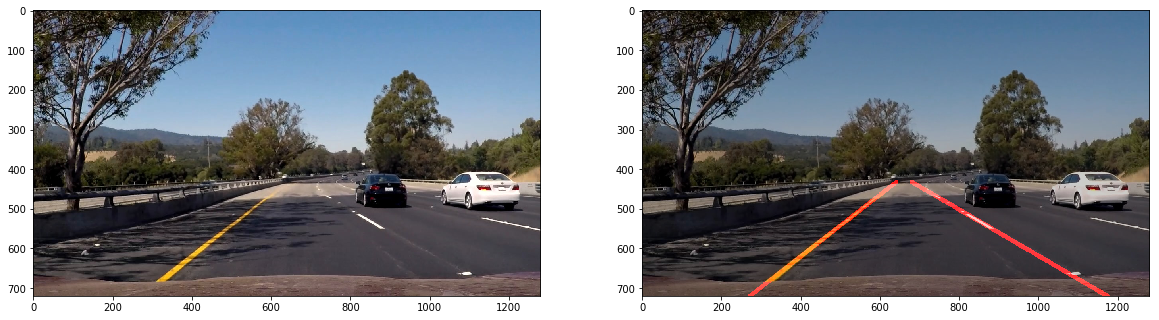

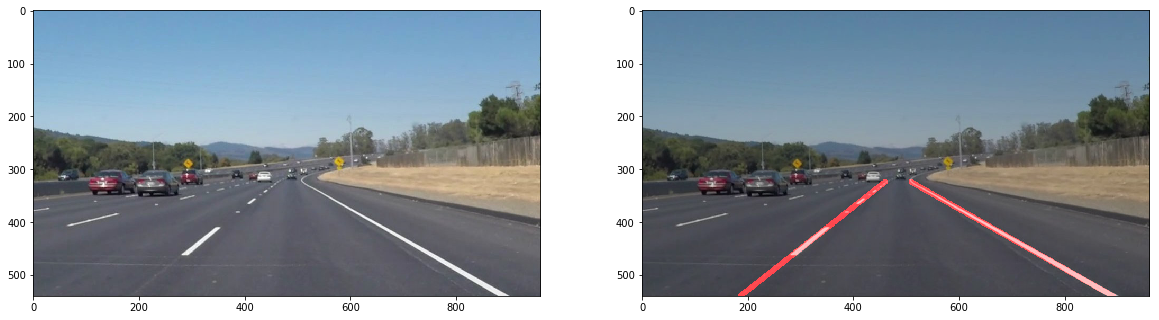

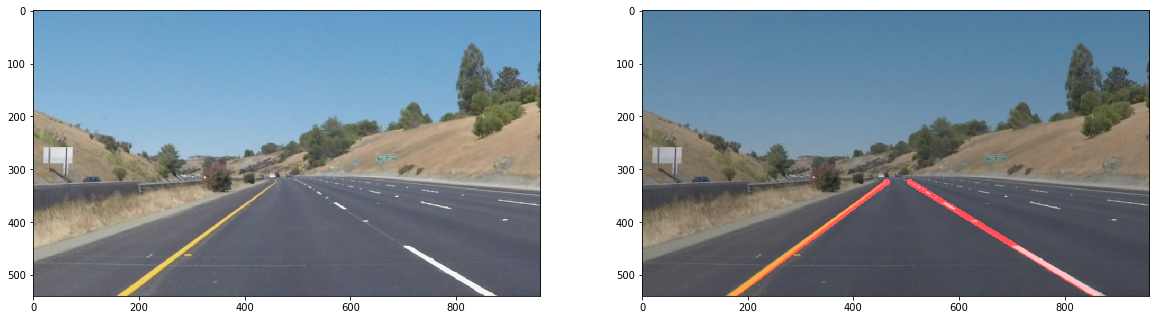

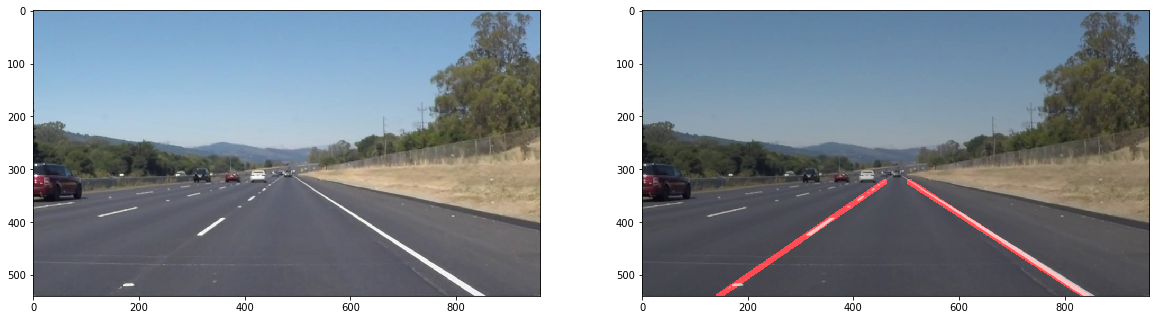

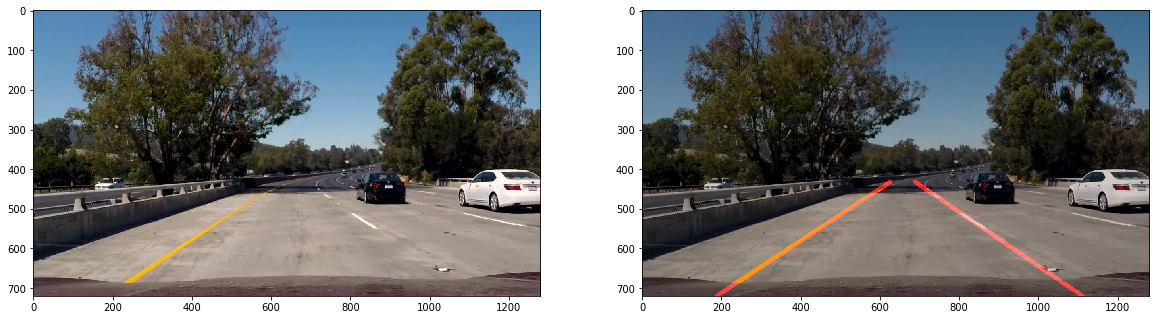

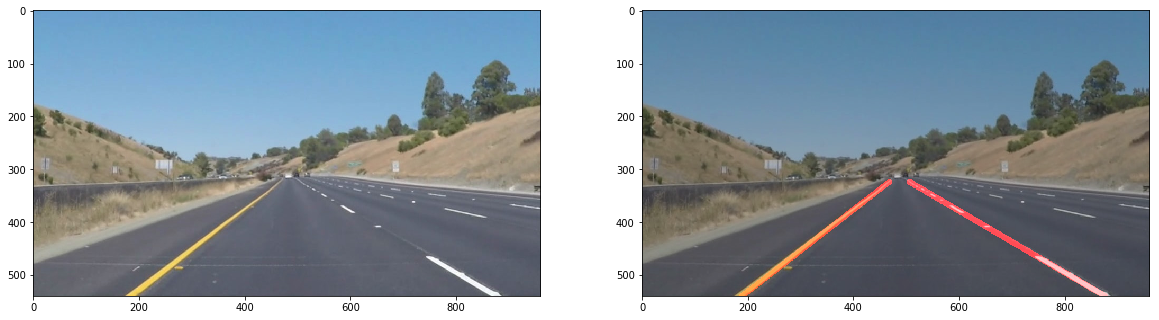

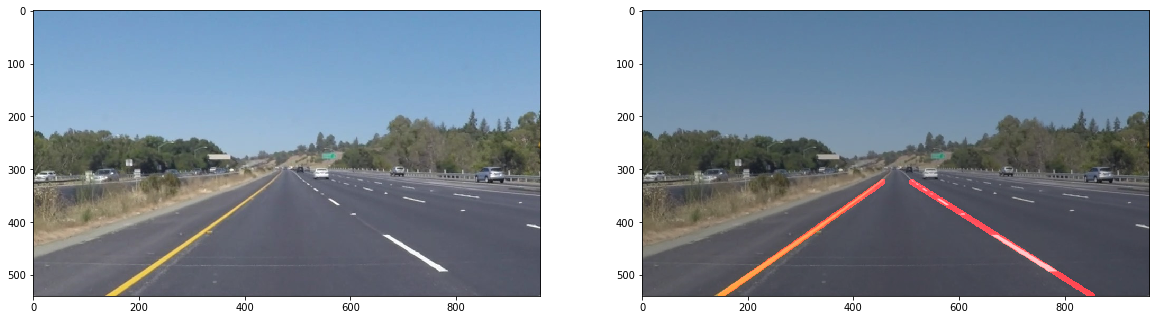

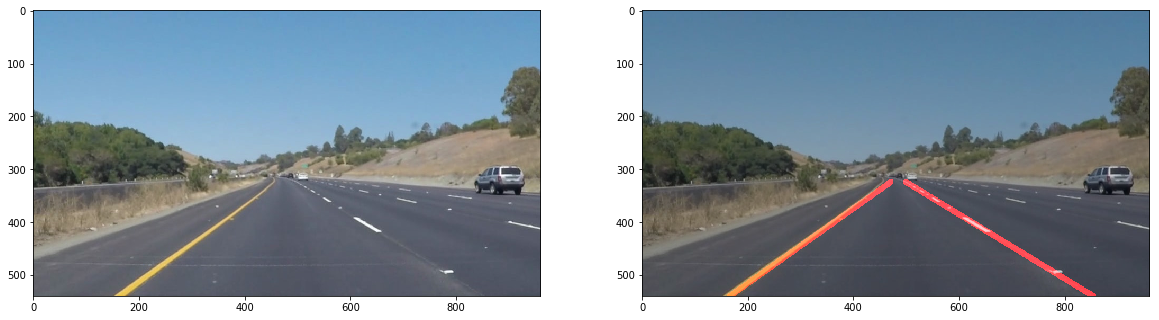

In [101]:
# then save them to the test_images directory.

# loop to run pipeline for all images in the directory
for test_img in test_images:
    img = mpimg.imread(os.path.join('test_images/', test_img))
    output_img = pipeline(img)
    fname = test_img
    cv2.imwrite(os.path.join('test_images_output', fname), cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    f, axarr = plt.subplots(1, 2, figsize=(20,20))
    # print(test_img)
    axarr[0].imshow(img)
    axarr[1].imshow(output_img)

## Test on Videos


In [102]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [103]:
def process_image(image_vid):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image_vid)
    return result

In [104]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 23.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.96 s, sys: 196 ms, total: 7.16 s
Wall time: 8.37 s


In [105]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:23<00:00, 28.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 21.9 s, sys: 752 ms, total: 22.6 s
Wall time: 24.4 s


In [106]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:17<00:00, 14.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.2 s, sys: 484 ms, total: 12.7 s
Wall time: 18.7 s
